# Taiwanese Credit Card Default Modeling.

The goal of this project to find a model which best predicts whether or not a person will default on their credit card payment. 

#### Data Set Information:

- This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

- NT is the abbreviation for New Taiwan.

#### Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005; 
    - X7 = the repayment status in August, 2005; . . .;
    - etc...
    - X11 = the repayment status in April, 2005. 
    - The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). 
    - X12 = amount of bill statement in September, 2005;
    - etc...
    - X13 = amount of bill statement in August, 2005; . . .; 
    - X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). 
    - X18 = amount paid in September, 2005; 
    - X19 = amount paid in August, 2005; . . .;
    - etc...
    - X23 = amount paid in April, 2005. 
    

Median salary by education level:

1. Graduate school and above = 831496
2. University = 575575
3. Junior college = 526270
4. Senior high school = 417073
5. Junior high school = 394230
6. Primary school, Supplementary school and illiteracy = 292370

References:

https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end

https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166

https://win.dgbas.gov.tw/fies/e12.asp?year=94

# Libraries

In [199]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, mutual_info_regression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from sklearn.metrics import confusion_matrix
import pprint

In [3]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

## Helper Functions

In [205]:
def heatmap_corr(dataframe):
    # Plots a heatmap of correlation between features with masking.
    fig, ax = plt.subplots(figsize=(20,20))
    mask=np.zeros_like(dataframe.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    color_map = sns.color_palette("hot_r")
    ax = sns.heatmap(dataframe.corr(), cmap = color_map, mask=mask, square=True, annot=True)

def knnTrainTest(k_number, X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=k_number)
    # train
    knn.fit(X_train, y_train)
    # test
    y_pred_class = knn.predict(X_test)


    # check Accuracy
    print('Test Accuracy score: ', accuracy_score(y_test, y_pred_class))
    # check F1 score
    print('Test F1 score: ', f1_score(y_test, y_pred_class))
    return y_pred_class

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def logiRegr(X_train, y_train, X_test, y_test,**kwargs):
    logreg = LogisticRegression(**kwargs)
    logreg.fit(X_train, y_train)
    # examine coefficients
    pprint.pprint(list(zip(X_train.columns,logreg.coef_[0])))
    # class predictions (not predicted probabilities)
    y_pred_class = logreg.predict(X_test)
    print('Classification Accuracy: ', format(accuracy_score(y_test, y_pred_class), '.3f'))
    print('Precision score: ', format(precision_score(y_test, y_pred_class), '.3f'))
    print('Recall score: ', format(recall_score(y_test, y_pred_class), '.3f'))
    print('F1 score: ', format(f1_score(y_test, y_pred_class), '.3f'))
    # plot confusion matrix
    cm = confusion_matrix(y_test,y_pred_class)
    classes = ['NON-default','DEFAULT']
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    
def deciTree(X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier() # Create Decision Tree classifer object
    clf = clf.fit(X_train,y_train) # Train Decision Tree Classifer
    y_pred_train = clf.predict(X_train) #predict the training set
    y_pred_test = clf.predict(X_test) #Predict the response for test dataset

    # Model Accuracy, how often is the classifier correct?
    print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train))
    print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test))

def gridHyper(estimator, params, cv, scoring, X_train, y_train, X_test, y_test):
    gridSearch = GridSearchCV(estimator, params, cv=cv, scoring=scoring) #create the instance of GridSearchCV
    gridSearch.fit(X_train,y_train) #fit the Gridsearch to our data
    # examine the best model
    print('Training Best Score: ', gridSearch.best_score_, '\n')
    print('Training Best Params: v \n', gridSearch.best_params_, '\n\n')
    print('Training Best Estimator: v \n', gridSearch.best_estimator_, '\n\n')
    
    
    # Use the best estimator to predict the response for test dataset
    y_pred = gridSearch.best_estimator_.predict(X_test)
    # Model Accuracy, how often is the classifier correct?
    print("Testing Accuracy:", metrics.f1_score(y_test, y_pred))
    return y_pred

## 1. Data Prep

In [168]:
df = pd.read_csv('classification_lab_data.csv')

In [169]:
df.head(30)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,50000,1,2,2,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1
1,30000,1,2,1,39,0,0,0,0,0,0,20893,22206,19273,16469,14670,11214,2007,2000,2000,417,1500,1500,0
2,260000,1,1,2,27,0,0,0,0,0,0,158711,129796,101721,76699,56738,39134,30000,4132,3410,2600,1800,1200,0
3,200000,2,2,1,33,0,0,0,0,0,0,23762,25944,26988,25237,22131,13774,4000,2000,600,3000,4000,100,0
4,50000,1,1,2,27,0,0,0,0,0,0,14614,15622,16342,17653,17697,18068,1558,1278,1589,633,656,783,0
5,150000,2,1,1,46,0,0,0,0,0,0,21787,22817,24134,24635,29032,29766,1382,1699,1200,5000,1214,1500,0
6,400000,2,2,2,41,-2,-2,-2,-2,-2,-2,43672,678,330,330,330,330,678,330,330,330,330,330,1
7,360000,2,2,2,31,0,-1,-1,-1,-2,-2,3386,5964,1340,1650,4350,4792,5964,1340,1650,4350,4792,40682,0
8,160000,2,2,2,32,2,2,2,2,-1,0,400,400,400,0,20818,20818,0,0,0,20818,0,0,0
9,500000,2,1,1,44,0,-1,-1,0,0,0,329570,71921,367979,294969,189612,128459,72001,368199,6486,234,90,167116,0


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 24 columns):
LIMIT_BAL                     23999 non-null int64
SEX                           23999 non-null int64
EDUCATION                     23999 non-null int64
MARRIAGE                      23999 non-null int64
AGE                           23999 non-null int64
PAY_0                         23999 non-null int64
PAY_2                         23999 non-null int64
PAY_3                         23999 non-null int64
PAY_4                         23999 non-null int64
PAY_5                         23999 non-null int64
PAY_6                         23999 non-null int64
BILL_AMT1                     23999 non-null int64
BILL_AMT2                     23999 non-null int64
BILL_AMT3                     23999 non-null int64
BILL_AMT4                     23999 non-null int64
BILL_AMT5                     23999 non-null int64
BILL_AMT6                     23999 non-null int64
PAY_AMT1                

In [171]:
df.isna().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [172]:
df[df.duplicated(keep="first")].count()

LIMIT_BAL                     21
SEX                           21
EDUCATION                     21
MARRIAGE                      21
AGE                           21
PAY_0                         21
PAY_2                         21
PAY_3                         21
PAY_4                         21
PAY_5                         21
PAY_6                         21
BILL_AMT1                     21
BILL_AMT2                     21
BILL_AMT3                     21
BILL_AMT4                     21
BILL_AMT5                     21
BILL_AMT6                     21
PAY_AMT1                      21
PAY_AMT2                      21
PAY_AMT3                      21
PAY_AMT4                      21
PAY_AMT5                      21
PAY_AMT6                      21
default payment next month    21
dtype: int64

In [173]:
dups = list(df[df.duplicated(keep="first")].index.values)
df.drop(df.index[dups],inplace=True)

In [174]:
df.reset_index(drop=True, inplace=True)

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23978 entries, 0 to 23977
Data columns (total 24 columns):
LIMIT_BAL                     23978 non-null int64
SEX                           23978 non-null int64
EDUCATION                     23978 non-null int64
MARRIAGE                      23978 non-null int64
AGE                           23978 non-null int64
PAY_0                         23978 non-null int64
PAY_2                         23978 non-null int64
PAY_3                         23978 non-null int64
PAY_4                         23978 non-null int64
PAY_5                         23978 non-null int64
PAY_6                         23978 non-null int64
BILL_AMT1                     23978 non-null int64
BILL_AMT2                     23978 non-null int64
BILL_AMT3                     23978 non-null int64
BILL_AMT4                     23978 non-null int64
BILL_AMT5                     23978 non-null int64
BILL_AMT6                     23978 non-null int64
PAY_AMT1                

## 2. EDA

In [176]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [177]:
df.rename({'PAY_6': 'Payment_Status_Apr', 'PAY_5': 'Payment_Status_May', 'PAY_4': 'Payment_Status_Jun', 
           'PAY_3': 'Payment_Status_Jul', 'PAY_2': 'Payment_Status_Aug', 'PAY_0': 'Payment_Status_Sep',
           'BILL_AMT6': 'Bill_Apr', 'BILL_AMT5': 'Bill_May', 'BILL_AMT4': 'Bill_Jun',
           'BILL_AMT3': 'Bill_Jul', 'BILL_AMT2': 'Bill_Aug', 'BILL_AMT1': 'Bill_Sep',
           'PAY_AMT6': 'Payments_Apr', 'PAY_AMT5': 'Payments_May', 'PAY_AMT4': 'Payments_Jun',
           'PAY_AMT3': 'Payments_Jul', 'PAY_AMT2': 'Payments_Aug', 'PAY_AMT1': 'Payments_Sep',
           'default payment next month': 'defaulted'}, axis=1, inplace=True)

In [178]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'Payment_Status_Sep', 'Payment_Status_Aug', 'Payment_Status_Jul',
       'Payment_Status_Jun', 'Payment_Status_May', 'Payment_Status_Apr',
       'Bill_Sep', 'Bill_Aug', 'Bill_Jul', 'Bill_Jun', 'Bill_May', 'Bill_Apr',
       'Payments_Sep', 'Payments_Aug', 'Payments_Jul', 'Payments_Jun',
       'Payments_May', 'Payments_Apr', 'defaulted'],
      dtype='object')

In [179]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,23978.0,167785.873718,129917.562562,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,23978.0,1.603595,0.489161,1.0,1.00,2.0,2.00,2.0
EDUCATION,23978.0,1.857161,0.791944,0.0,1.00,2.0,2.00,6.0
MARRIAGE,23978.0,1.550755,0.522455,0.0,1.00,2.0,2.00,3.0
AGE,23978.0,35.525440,9.255010,21.0,28.00,34.0,42.00,79.0
Payment_Status_Sep,23978.0,-0.015014,1.120667,-2.0,-1.00,0.0,0.00,8.0
Payment_Status_Aug,23978.0,-0.133497,1.192413,-2.0,-1.00,0.0,0.00,8.0
Payment_Status_Jul,23978.0,-0.164401,1.192697,-2.0,-1.00,0.0,0.00,8.0
Payment_Status_Jun,23978.0,-0.215906,1.167915,-2.0,-1.00,0.0,0.00,8.0
Payment_Status_May,23978.0,-0.260197,1.132201,-2.0,-1.00,0.0,0.00,8.0


In [180]:
df['EDUCATION'].value_counts()

2    11183
1     8428
3     3992
5      223
4      100
6       41
0       11
Name: EDUCATION, dtype: int64

In [181]:
df.loc[df['EDUCATION'].isin([0,4,5,6]), 'defaulted'].value_counts()

0    351
1     24
Name: defaulted, dtype: int64

In [182]:
df.loc[df['EDUCATION']==0]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,Payment_Status_Sep,Payment_Status_Aug,Payment_Status_Jul,Payment_Status_Jun,Payment_Status_May,Payment_Status_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,Payments_Sep,Payments_Aug,Payments_Jul,Payments_Jun,Payments_May,Payments_Apr,defaulted
1295,50000,2,0,1,40,0,0,0,0,0,0,44749,46229,46798,47647,40500,41921,2229,2298,2100,2500,1921,8432,0
2033,270000,1,0,2,39,1,-1,-1,-1,-1,-2,0,10193,69553,18607,0,0,10193,70213,19008,399,0,0,0
3940,160000,1,0,1,47,-1,-1,-1,-1,0,-1,386,907,3707,6987,3853,4613,907,3707,6991,77,4613,4099,0
6042,230000,2,0,2,47,-1,-1,-1,2,-1,-1,8394,5743,1336,255,5425,4838,5743,1598,0,5425,4838,3840,0
7924,350000,2,0,2,53,-1,-1,-1,-1,-1,-1,5095,4815,61044,22611,1385,6043,4840,61349,22687,1389,6058,1153,0
8797,210000,1,0,2,45,-2,-2,-2,-2,-2,-2,2563,5854,1032,788,3499,3372,5854,1032,788,3565,3372,15381,0
10417,250000,1,0,1,35,-2,-2,-2,-2,-2,-2,22839,7745,12035,33604,0,1190,7783,12046,33718,0,1190,590,0
10559,290000,2,0,2,38,1,-1,-1,-1,-1,-1,0,1437,3070,1406,2196,1481,1437,3078,1406,2196,1481,0,0
11983,360000,1,0,2,30,0,0,-1,0,0,-1,40250,23022,12272,34345,36777,30,23000,12280,25007,25008,1767,3300,0
15310,220000,2,0,1,35,-2,-2,-2,-2,-2,-2,0,319,10567,319,319,319,319,10567,319,319,319,2420,0


In [183]:
df = df[df.EDUCATION != 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23967 entries, 0 to 23977
Data columns (total 24 columns):
LIMIT_BAL             23967 non-null int64
SEX                   23967 non-null int64
EDUCATION             23967 non-null int64
MARRIAGE              23967 non-null int64
AGE                   23967 non-null int64
Payment_Status_Sep    23967 non-null int64
Payment_Status_Aug    23967 non-null int64
Payment_Status_Jul    23967 non-null int64
Payment_Status_Jun    23967 non-null int64
Payment_Status_May    23967 non-null int64
Payment_Status_Apr    23967 non-null int64
Bill_Sep              23967 non-null int64
Bill_Aug              23967 non-null int64
Bill_Jul              23967 non-null int64
Bill_Jun              23967 non-null int64
Bill_May              23967 non-null int64
Bill_Apr              23967 non-null int64
Payments_Sep          23967 non-null int64
Payments_Aug          23967 non-null int64
Payments_Jul          23967 non-null int64
Payments_Jun          23967 non

In [106]:
df.loc[df['Payment_Status_Apr']==8]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,Payment_Status_Sep,Payment_Status_Aug,Payment_Status_Jul,Payment_Status_Jun,Payment_Status_May,Payment_Status_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,Payments_Sep,Payments_Aug,Payments_Jul,Payments_Jun,Payments_May,Payments_Apr,defaulted
9313,30000,1,1,1,47,2,2,8,8,8,8,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0,1
13922,100000,1,2,2,30,1,3,7,6,7,8,72652,90461,89011,96593,105083,103522,20000,0,10000,10000,0,0,1


In [113]:
df.loc[df['Payment_Status_Apr']==3]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,Payment_Status_Sep,Payment_Status_Aug,Payment_Status_Jul,Payment_Status_Jun,Payment_Status_May,Payment_Status_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,Payments_Sep,Payments_Aug,Payments_Jul,Payments_Jun,Payments_May,Payments_Apr,defaulted
199,140000,1,1,1,57,2,2,2,2,2,3,108660,105504,113177,113622,116396,115826,0,10970,3805,4747,1932,8337,1
385,240000,2,2,1,44,-2,-1,-1,2,2,3,16925,1411,1696,1437,2714,2202,1411,1200,0,1479,0,0,0
840,10000,1,2,1,30,3,2,2,3,3,3,1050,1050,1050,1050,1050,1050,0,0,0,0,0,0,1
849,20000,2,2,2,24,2,0,0,0,0,3,2968,3980,5075,5979,6796,6463,1223,1318,1183,1000,0,0,1
1054,100000,1,2,1,29,2,2,2,2,3,3,81839,82781,85536,90018,91151,89429,3200,5000,6800,3500,0,3400,1
1112,60000,2,3,1,34,2,2,2,4,3,3,6731,7777,9502,9217,9722,9291,1300,2000,0,800,0,0,0
1224,80000,2,3,1,43,2,2,3,3,2,3,68152,71459,73690,71908,76294,74788,5000,4000,0,5700,0,0,1
1246,100000,2,2,2,24,2,2,2,2,2,3,93330,95285,96674,97983,102803,100960,4400,3800,3800,7300,0,679,1
1490,300000,2,1,2,25,1,5,4,3,2,3,315632,309330,302869,306395,311256,305413,0,0,10000,10000,0,0,1
1782,70000,2,2,1,33,0,0,5,4,3,3,56778,75037,73326,71568,72540,71148,20000,0,0,2700,0,0,0


### 2a. Kitchen Sink Model

In [185]:
X_base = df.drop('defaulted', axis = 1)
y_base = df['defaulted']
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, random_state=1)

In [186]:
scaler = StandardScaler()  
scaler.fit(X_base_train)

X_base_train_scaled = pd.DataFrame(scaler.transform(X_base_train), columns=X_base_train.columns) 
X_base_test_scaled = pd.DataFrame(scaler.transform(X_base_test), columns=X_base_test.columns)

In [206]:
logiRegr(X_base_train_scaled,y_base_train,X_base_test_scaled,y_base_test)

[('LIMIT_BAL', -0.12535703487050326),
 ('SEX', -0.05338145491714185),
 ('EDUCATION', -0.06839512575313254),
 ('MARRIAGE', -0.08661200097645053),
 ('AGE', 0.07189547422963871),
 ('Payment_Status_Sep', 0.6549284507170701),
 ('Payment_Status_Aug', 0.0841529805009638),
 ('Payment_Status_Jul', 0.09036131780650479),
 ('Payment_Status_Jun', 0.057898678816880746),
 ('Payment_Status_May', 0.013372208375293534),
 ('Payment_Status_Apr', 0.033077590283955925),
 ('Bill_Sep', -0.31800630697919063),
 ('Bill_Aug', 0.19733727500756035),
 ('Bill_Jul', 0.000331859011339387),
 ('Bill_Jun', 0.05823713094425006),
 ('Bill_May', 0.08237818803781616),
 ('Bill_Apr', -0.10812937189086541),
 ('Payments_Sep', -0.2293174103840951),
 ('Payments_Aug', -0.10796362502007548),
 ('Payments_Jul', -0.042168207185497006),
 ('Payments_Jun', -0.064314019974771),
 ('Payments_May', -0.006225668537229919),
 ('Payments_Apr', -0.03932189434981095)]
Classification Accuracy:  0.807
Precision score:  0.685
Recall score:  0.240
F1 sco

/Users/jmcneilkeller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [114]:
def distplot(data,bins=10,color='indigo'):
    plt.rcParams["patch.force_edgecolor"] = True
    for column in data:
        sns.distplot(data[column], bins=bins, color=color,
                          hist_kws=dict(edgecolor="k", linewidth=2))
        plt.show()

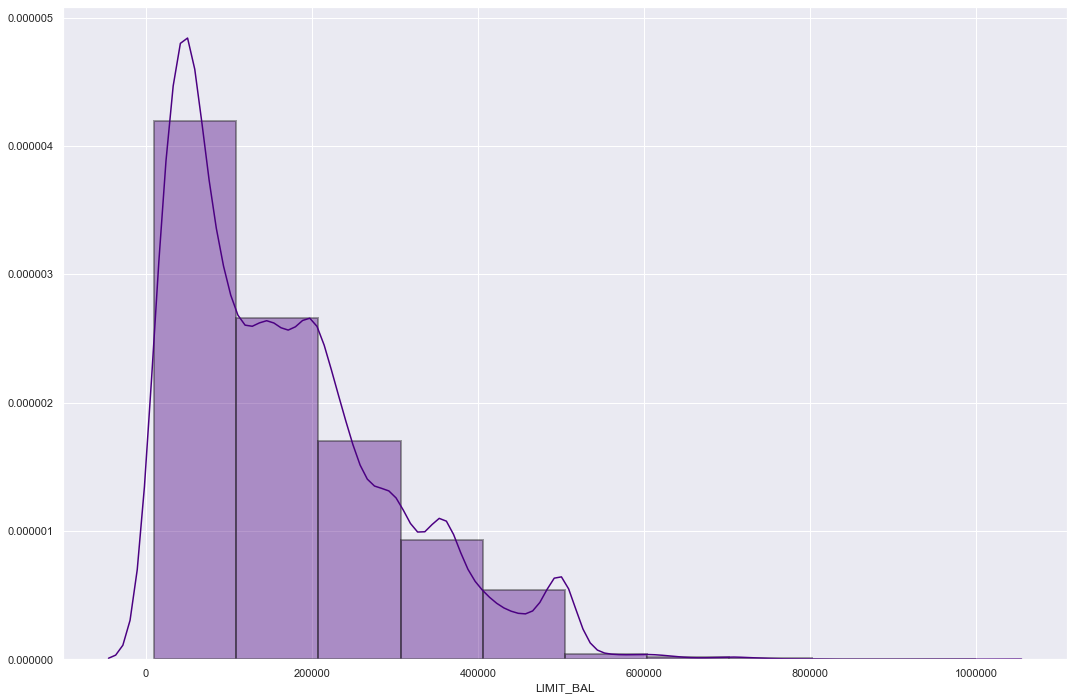

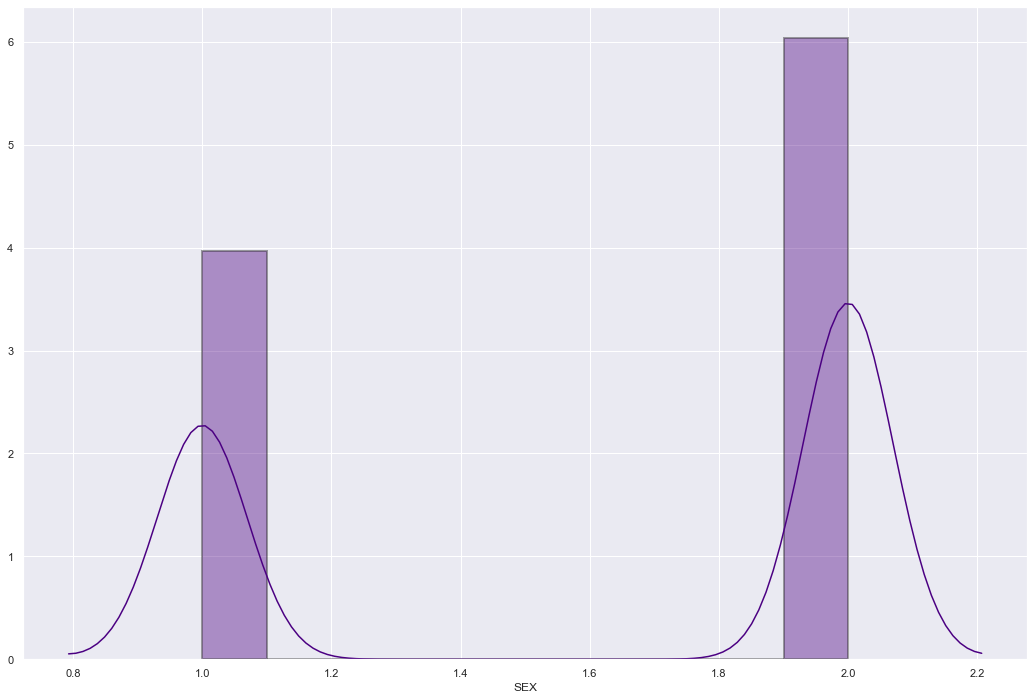

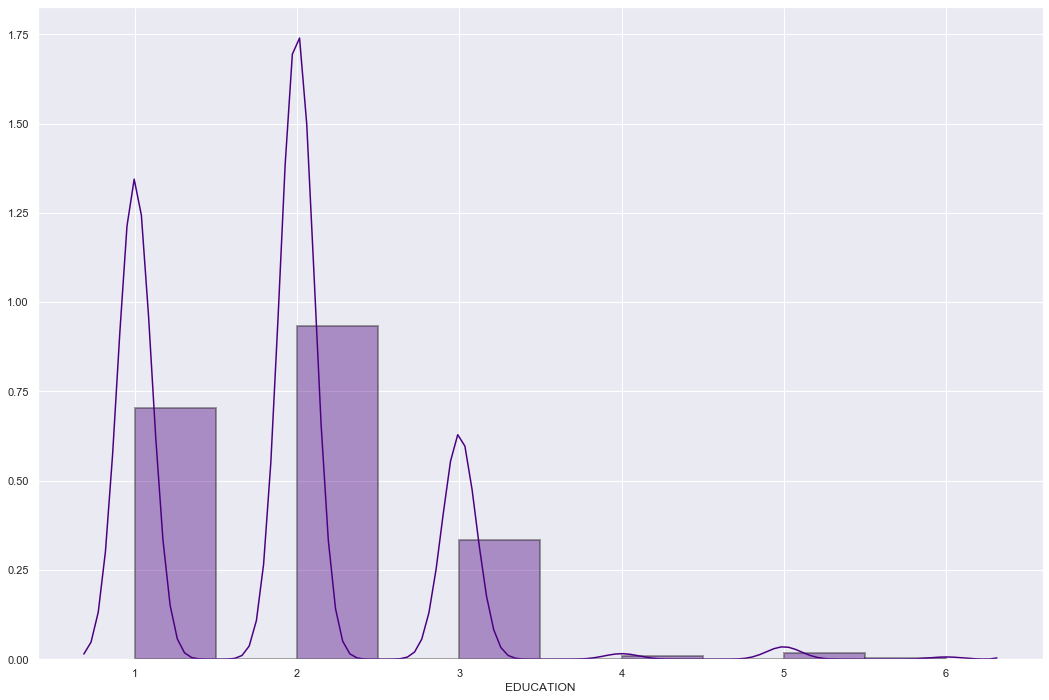

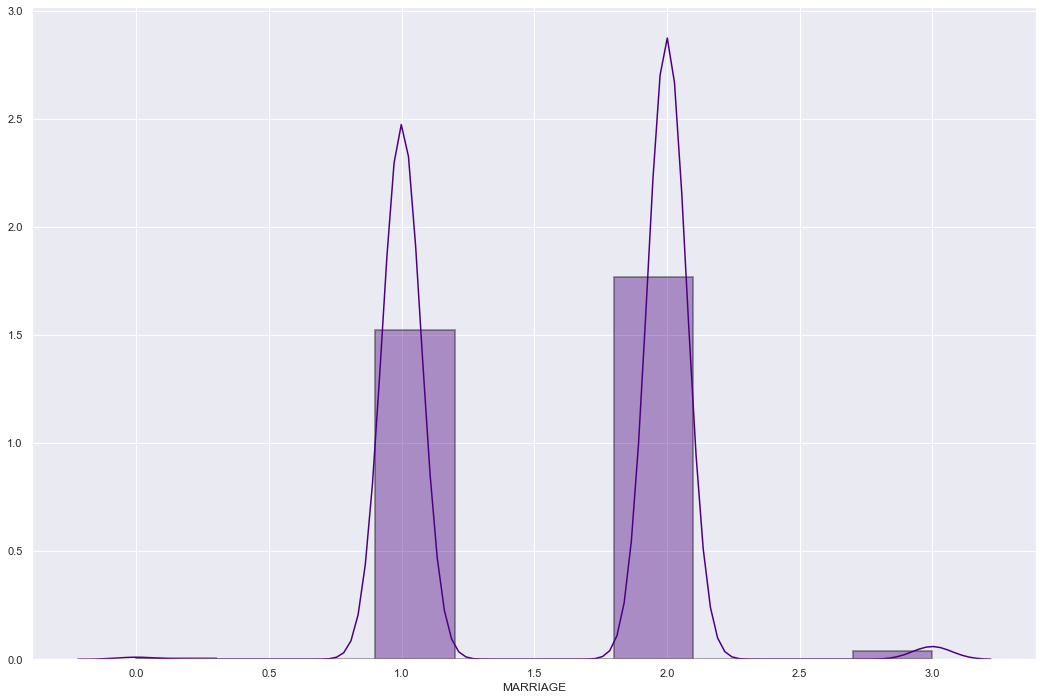

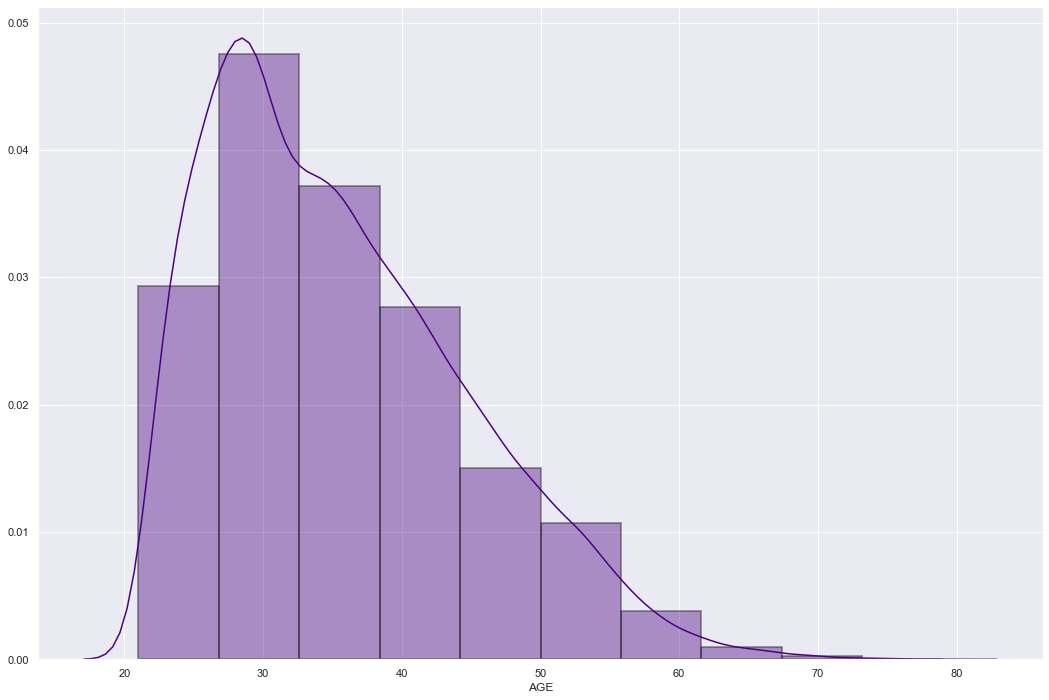

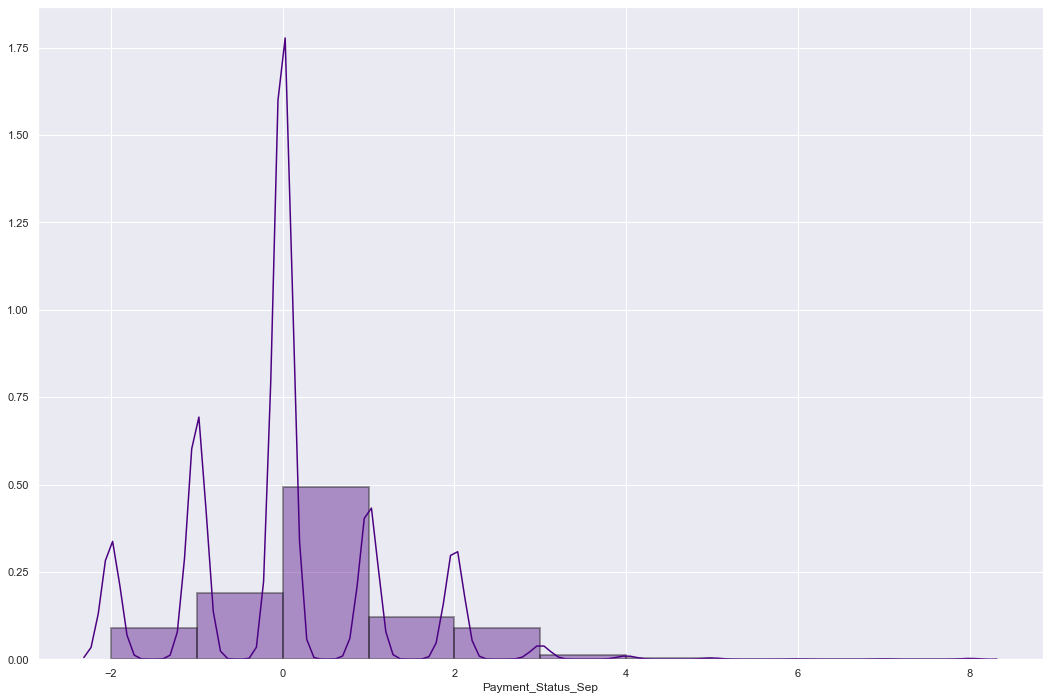

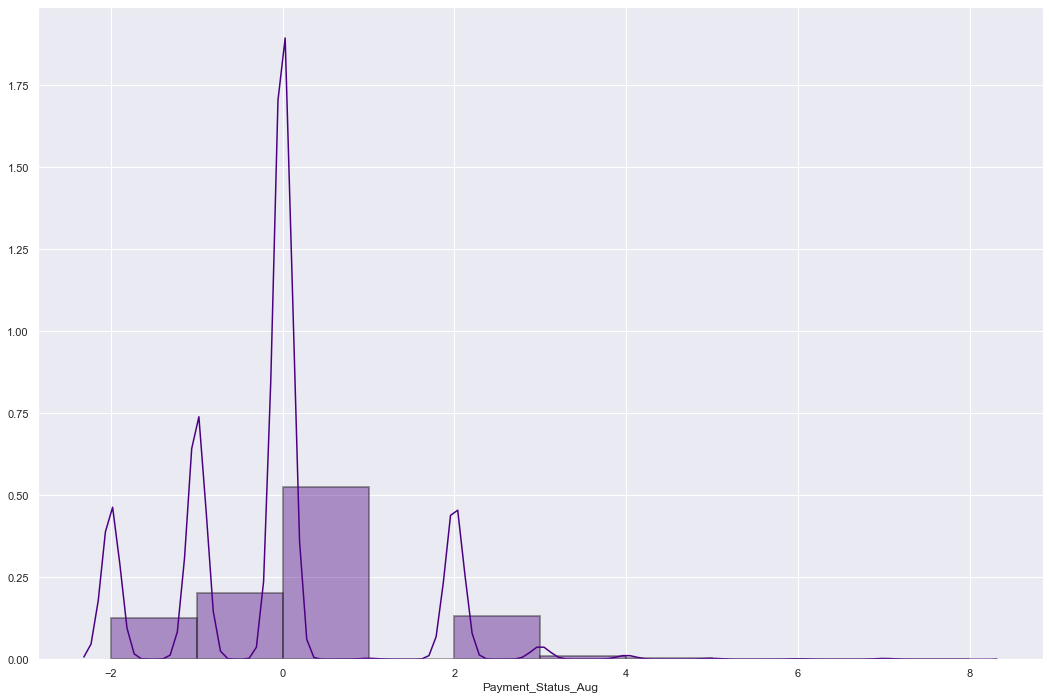

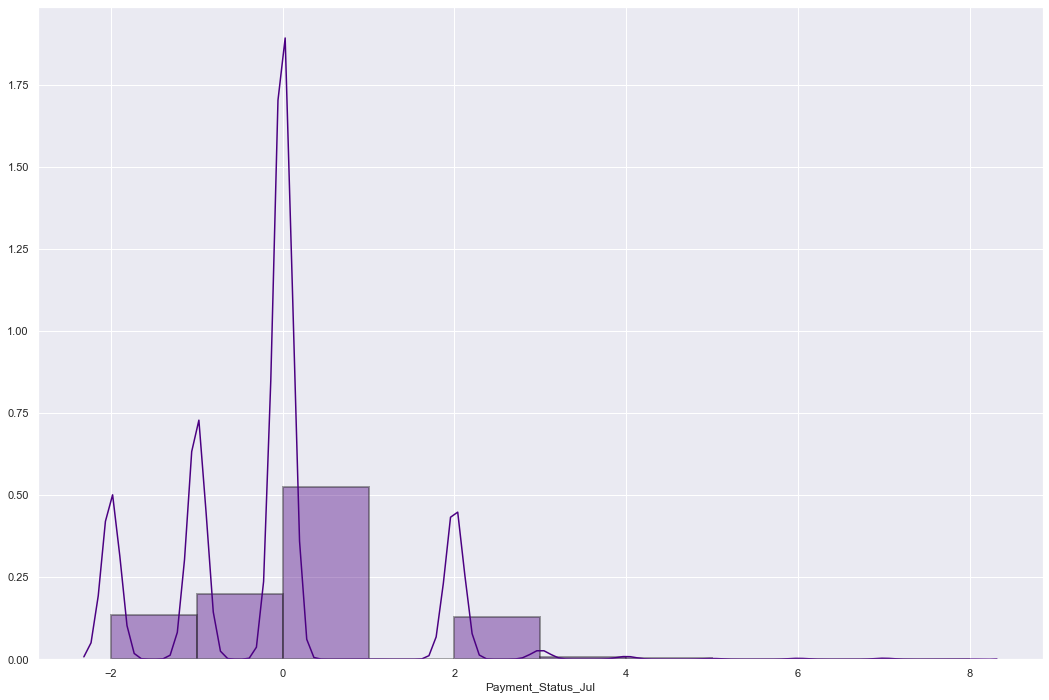

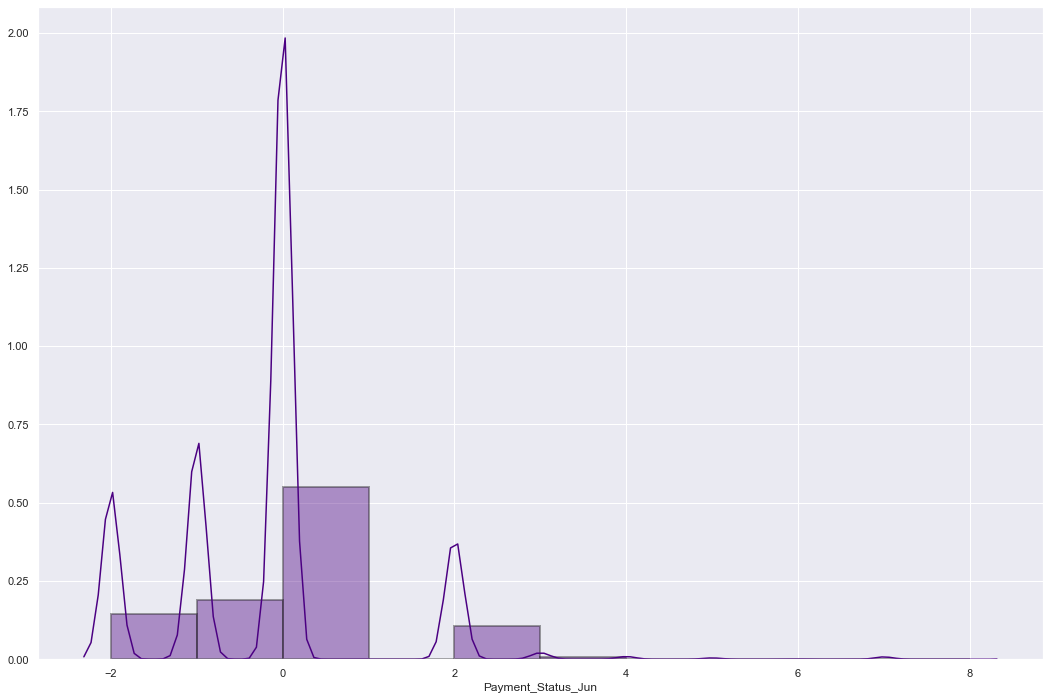

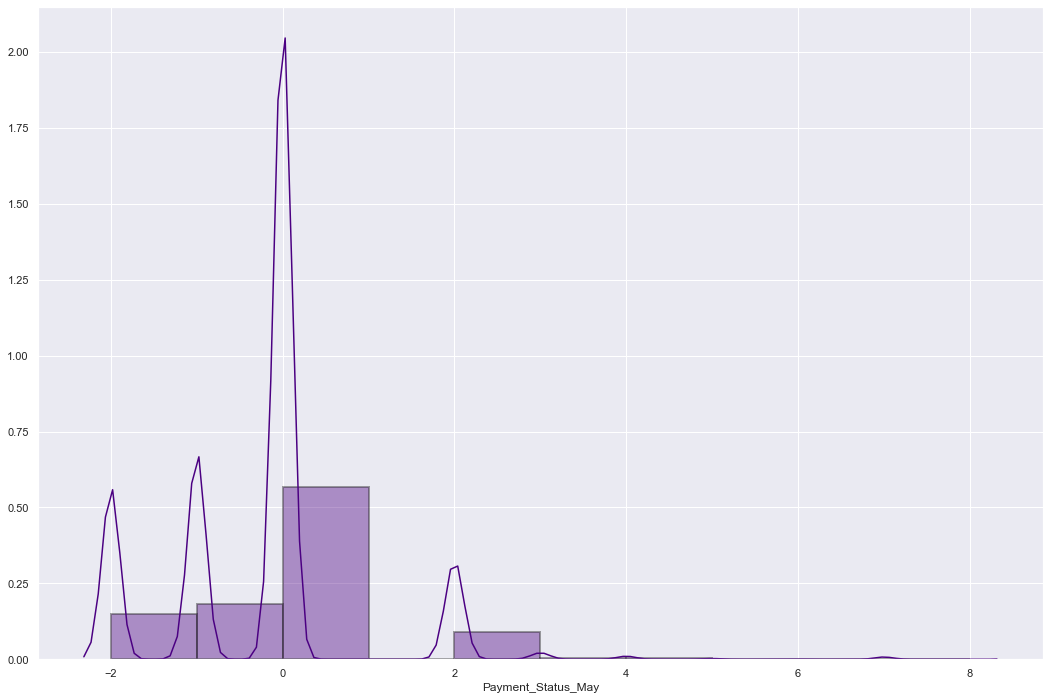

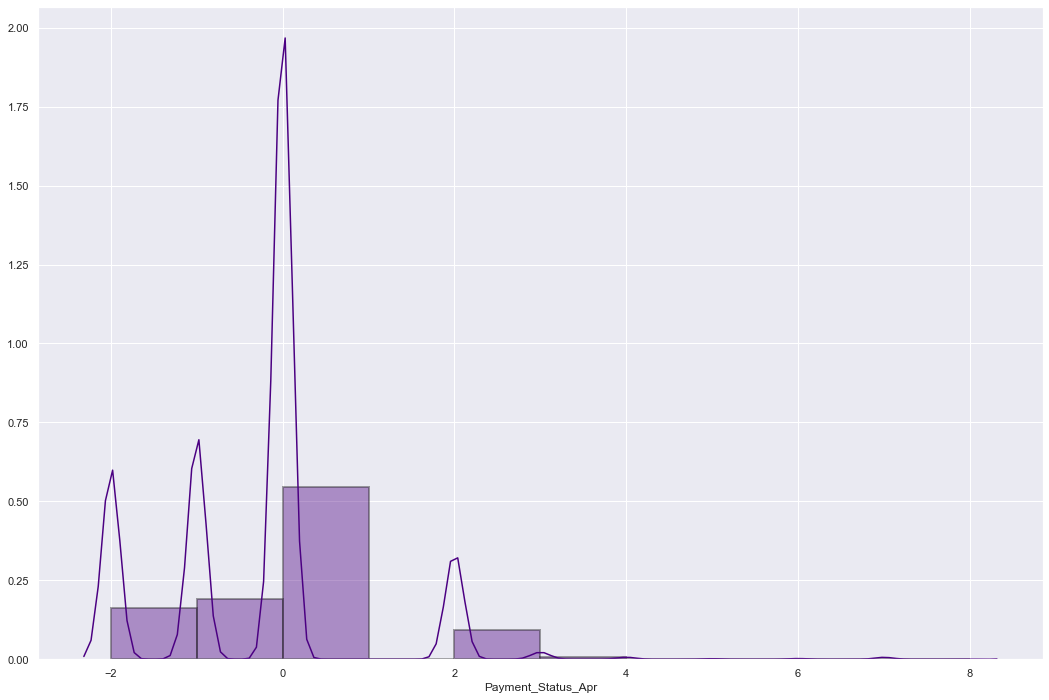

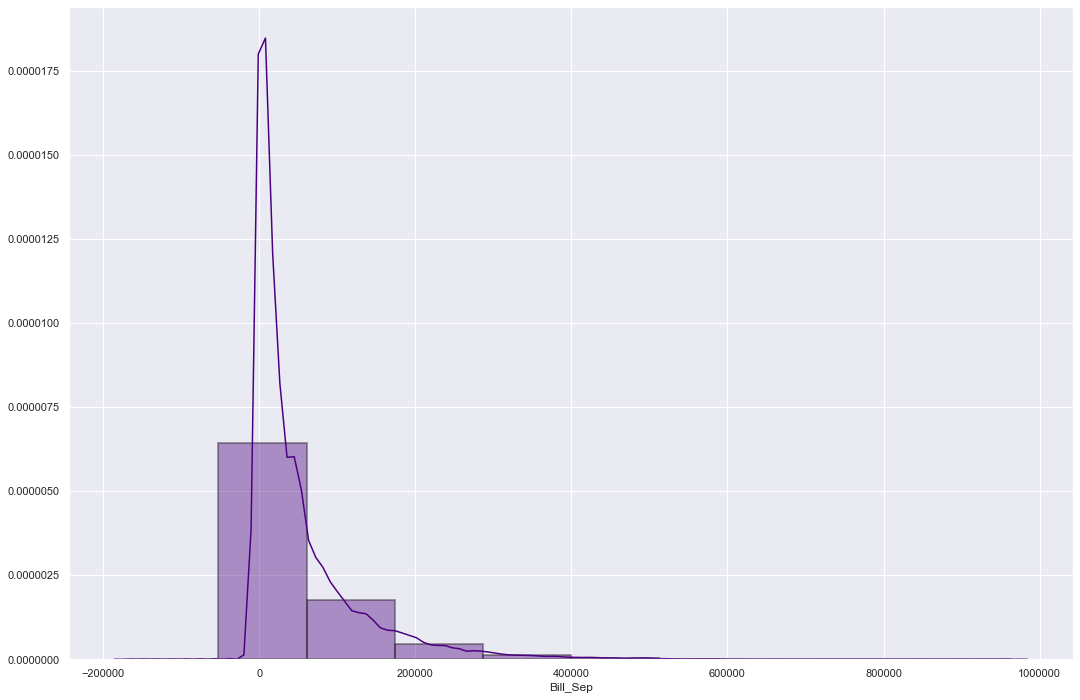

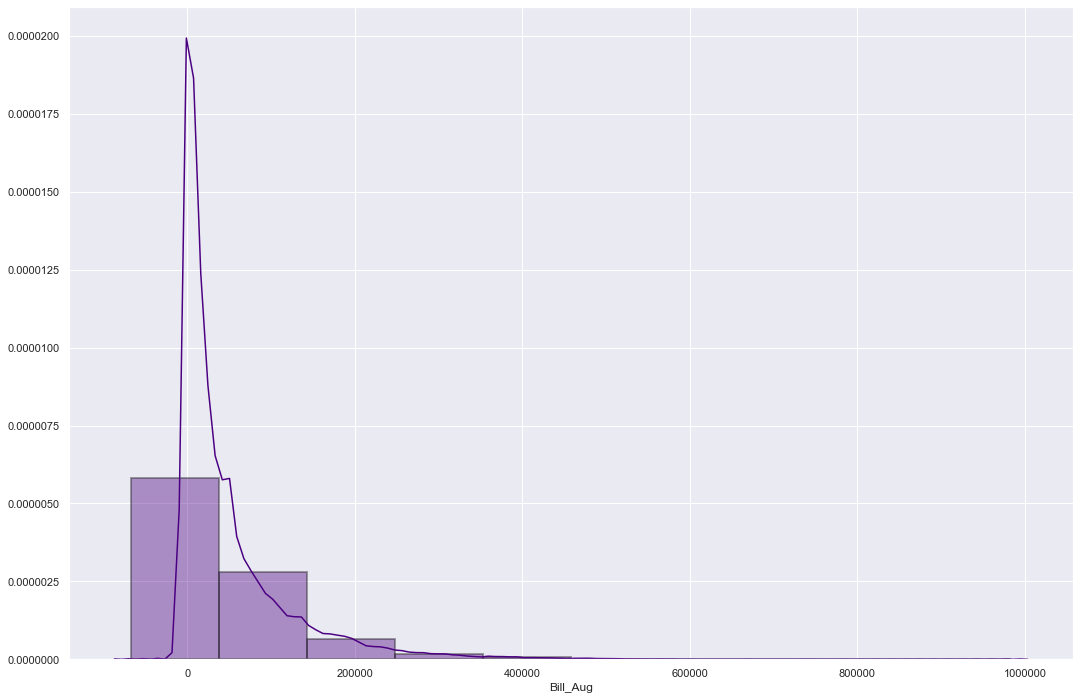

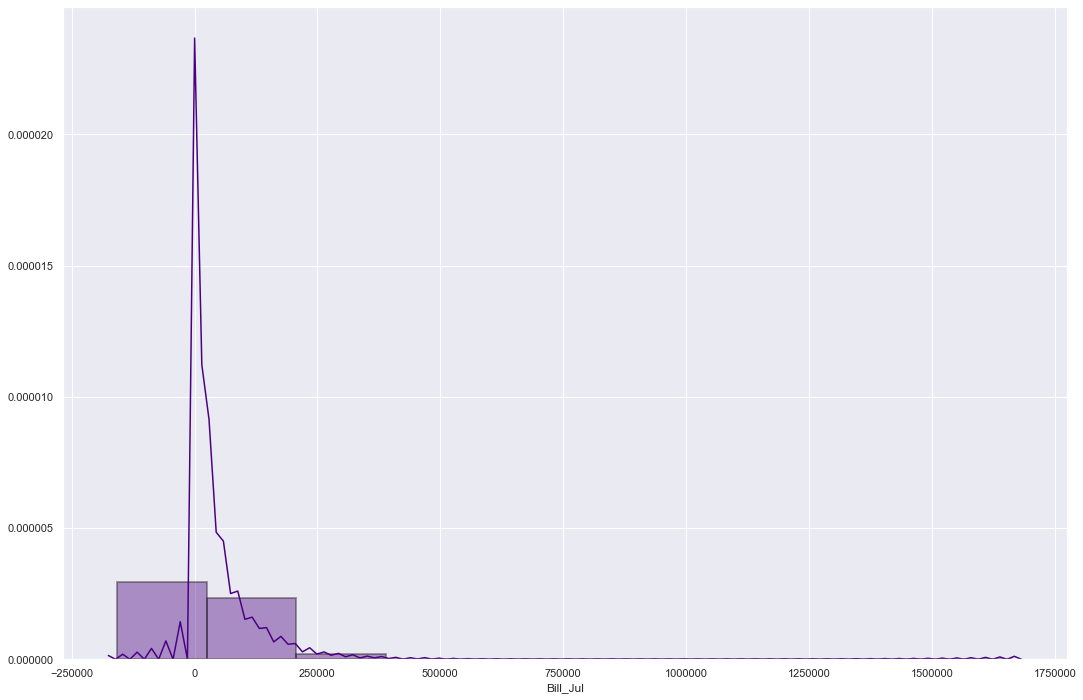

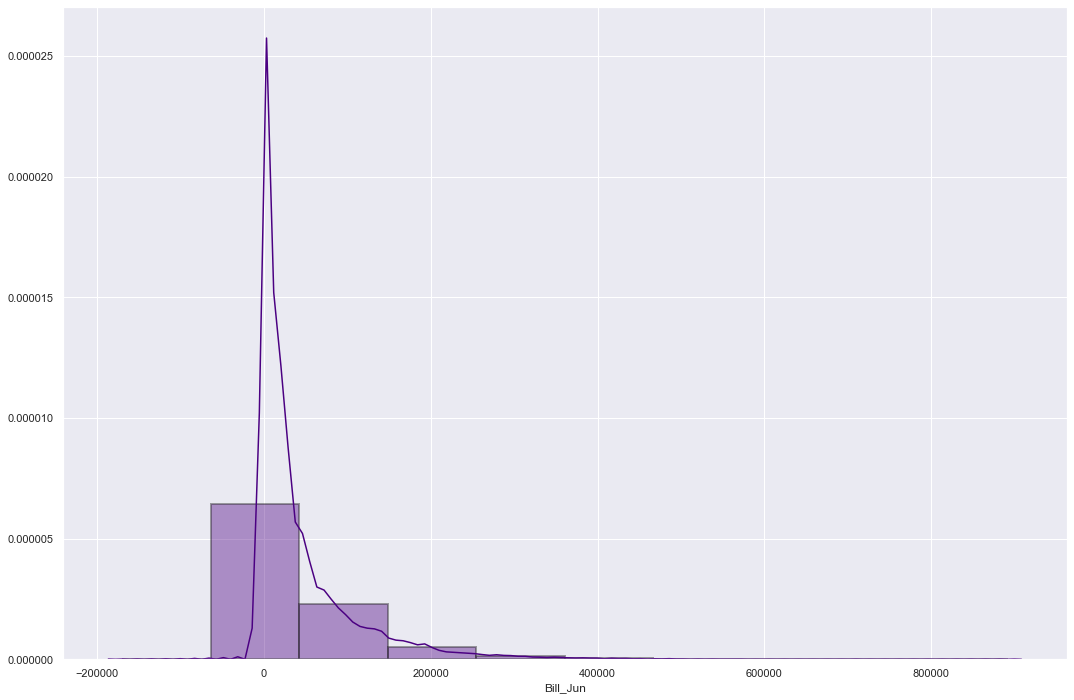

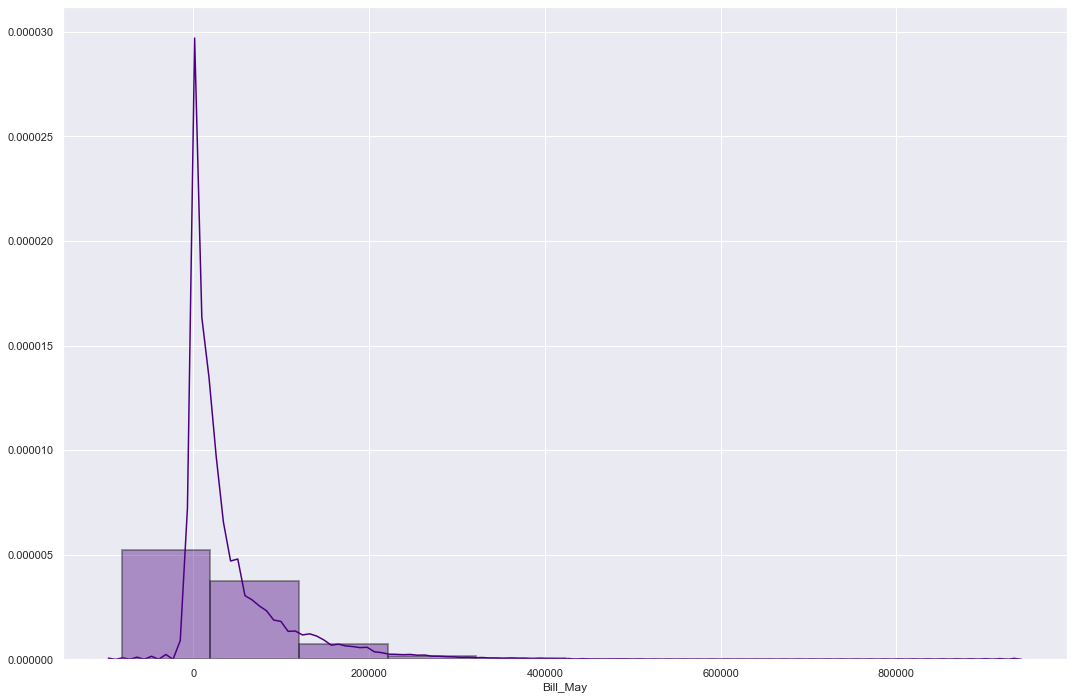

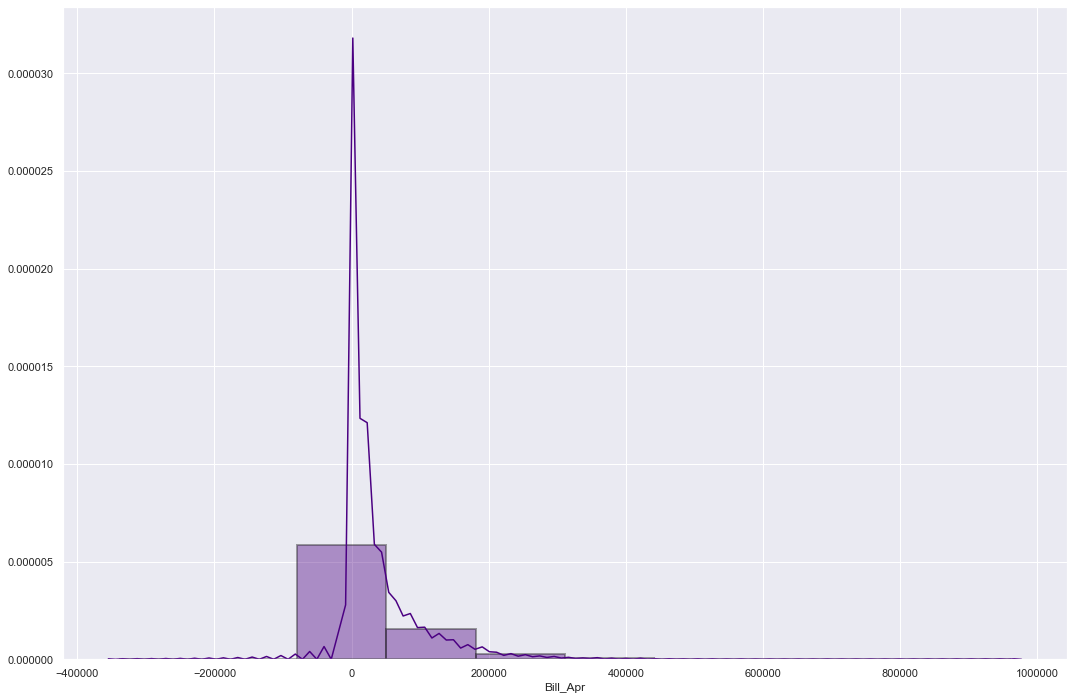

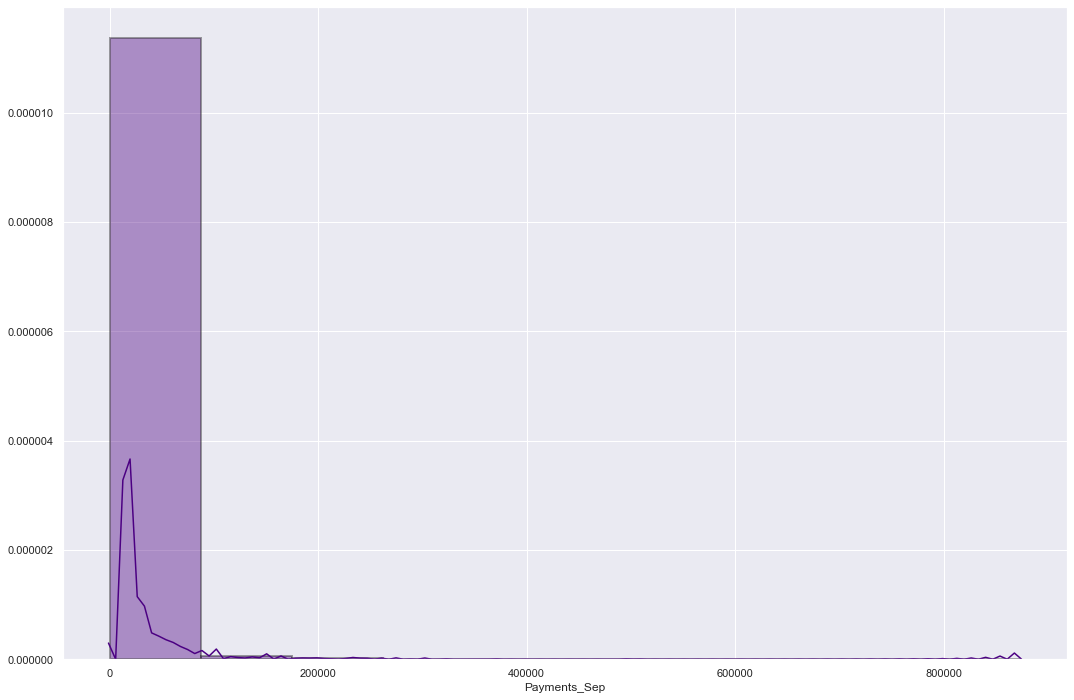

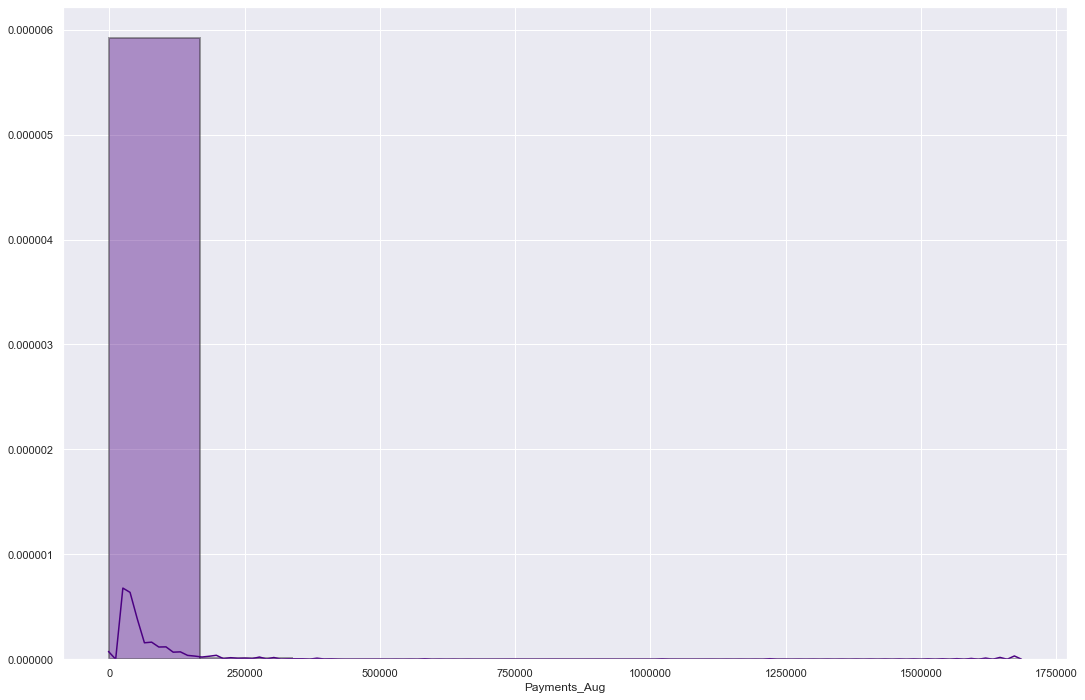

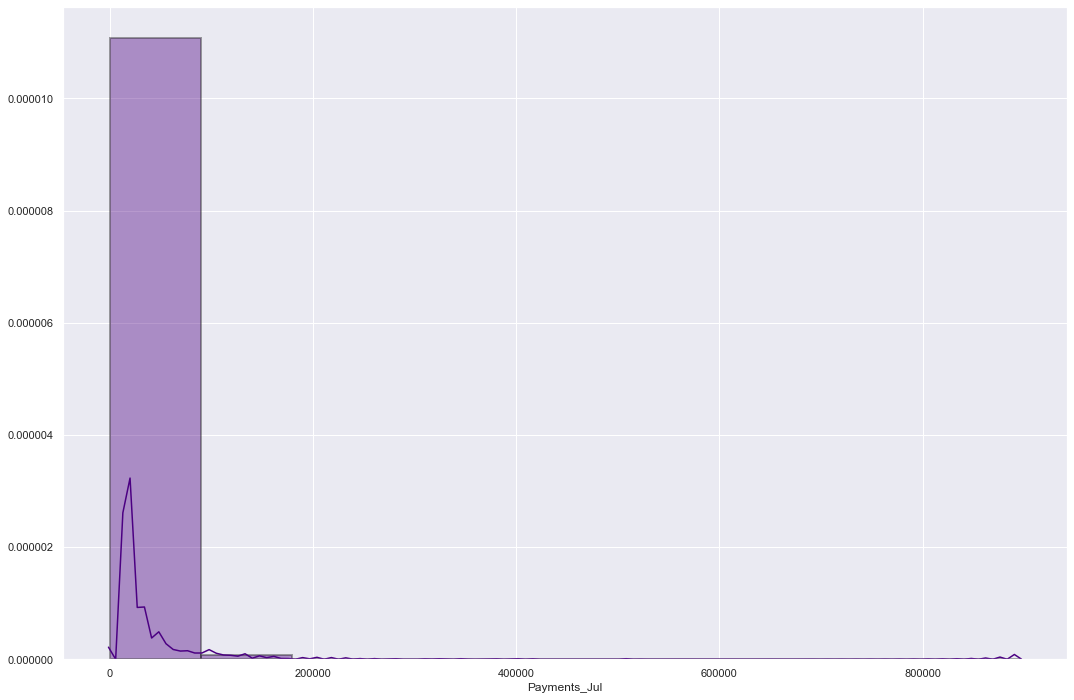

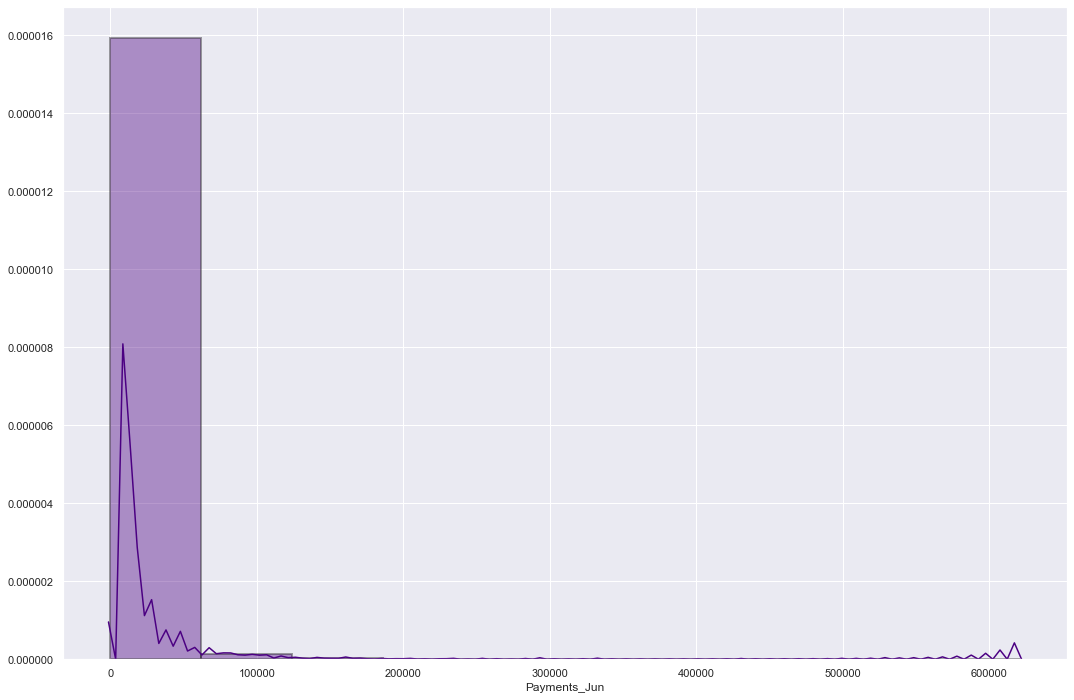

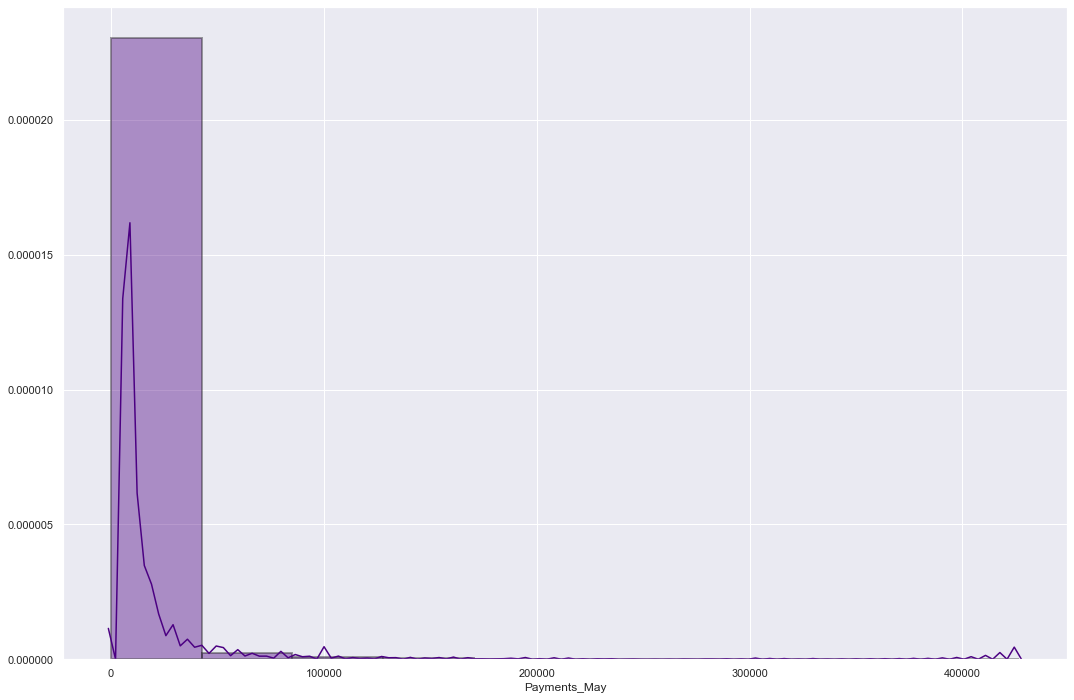

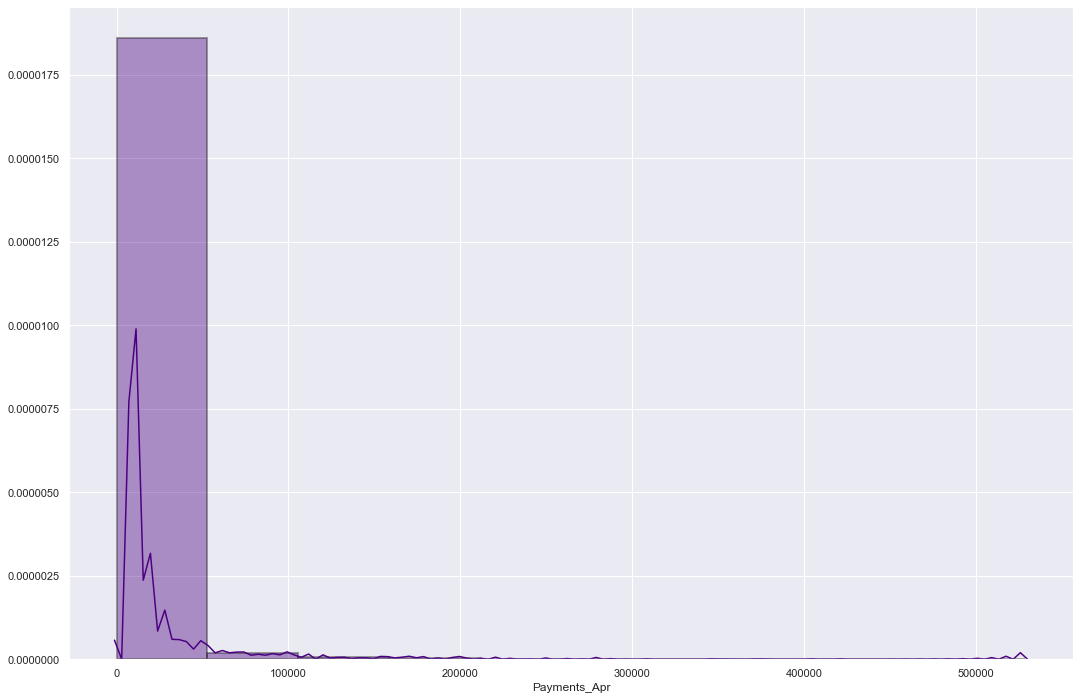

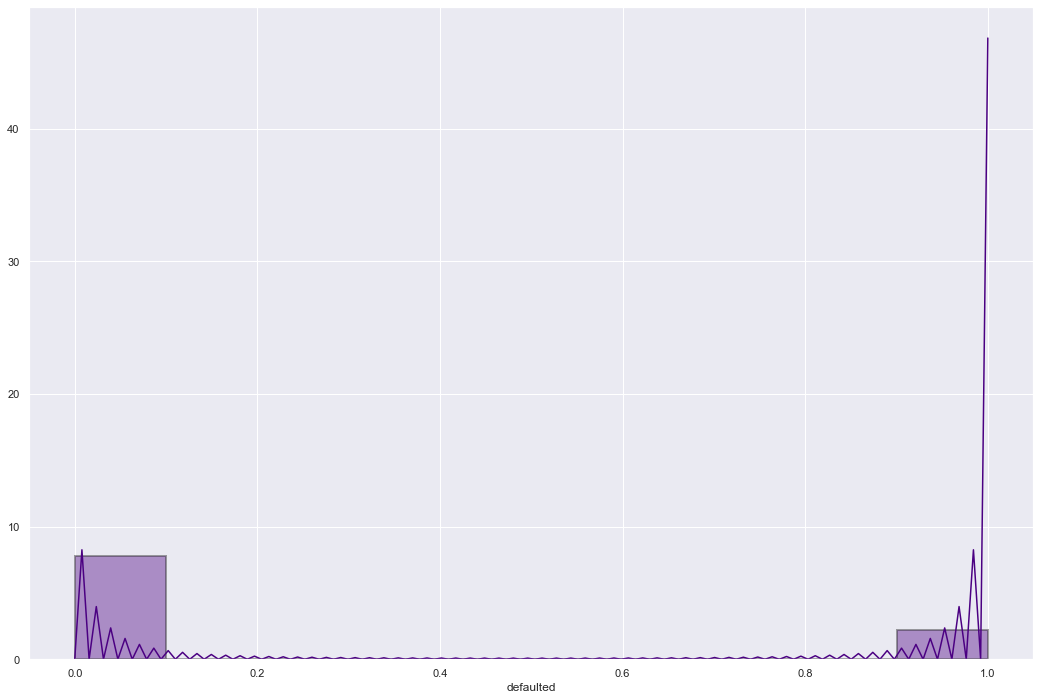

In [115]:
distplot(df)

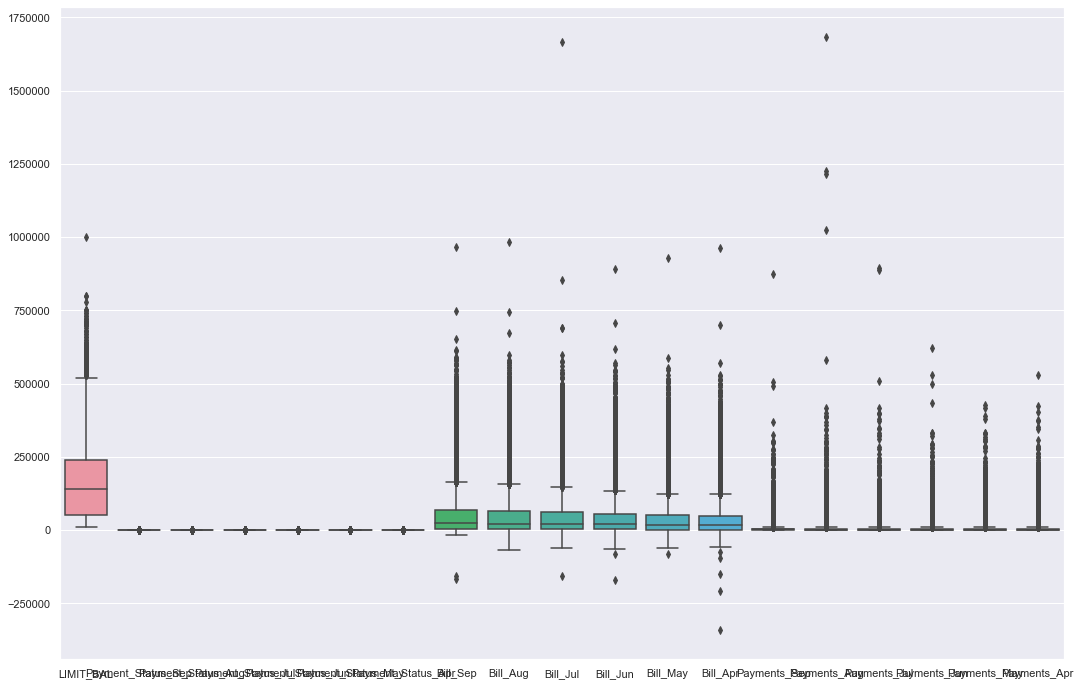

In [37]:
cols = df.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'defaulted'], axis=1)
sns.set(rc={'figure.figsize':(18,12)})
sns.boxplot(data=cols)

In [38]:
df = df[(np.abs(stats.zscore(df)) < 4).all(axis=1)]

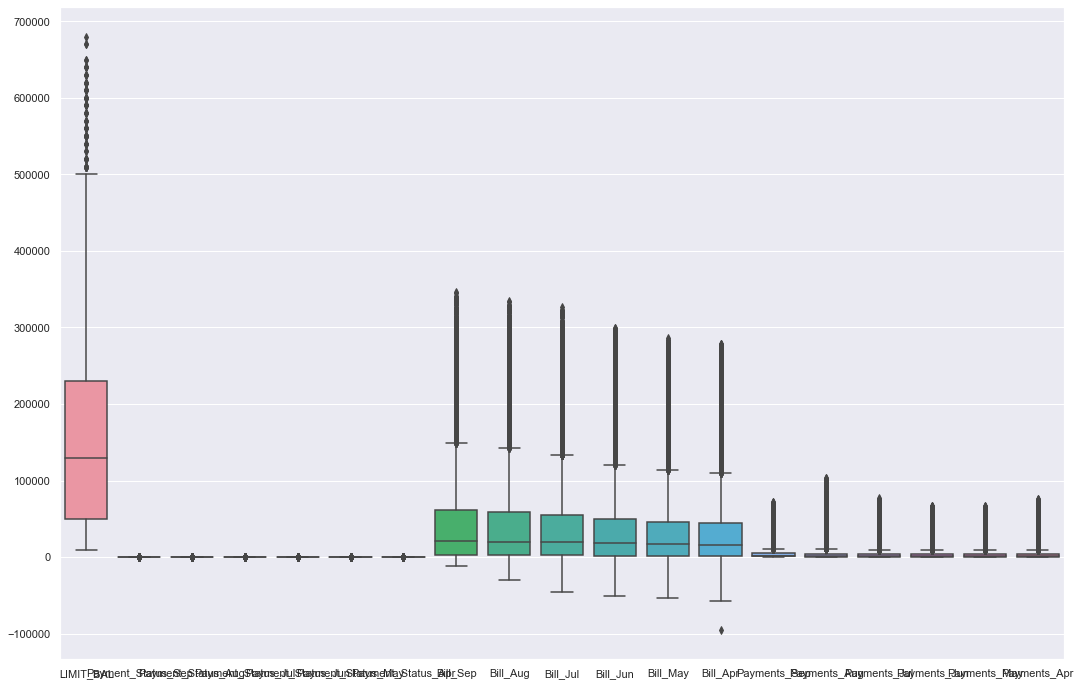

In [39]:
cols = df.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'defaulted'], axis=1)
sns.set(rc={'figure.figsize':(18,12)})
sns.boxplot(data=cols)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22327 entries, 0 to 23977
Data columns (total 24 columns):
LIMIT_BAL             22327 non-null int64
SEX                   22327 non-null int64
EDUCATION             22327 non-null int64
MARRIAGE              22327 non-null int64
AGE                   22327 non-null int64
Payment_Status_Sep    22327 non-null int64
Payment_Status_Aug    22327 non-null int64
Payment_Status_Jul    22327 non-null int64
Payment_Status_Jun    22327 non-null int64
Payment_Status_May    22327 non-null int64
Payment_Status_Apr    22327 non-null int64
Bill_Sep              22327 non-null int64
Bill_Aug              22327 non-null int64
Bill_Jul              22327 non-null int64
Bill_Jun              22327 non-null int64
Bill_May              22327 non-null int64
Bill_Apr              22327 non-null int64
Payments_Sep          22327 non-null int64
Payments_Aug          22327 non-null int64
Payments_Jul          22327 non-null int64
Payments_Jun          22327 non

In [41]:
df.corr()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,Payment_Status_Sep,Payment_Status_Aug,Payment_Status_Jul,Payment_Status_Jun,Payment_Status_May,Payment_Status_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,Payments_Sep,Payments_Aug,Payments_Jul,Payments_Jun,Payments_May,Payments_Apr,defaulted
LIMIT_BAL,1.000000,0.035262,-0.232984,-0.110221,0.129372,-0.285624,-0.313460,-0.307553,-0.291064,-0.274958,-0.260282,0.180200,0.167266,0.170288,0.175169,0.175233,0.165411,0.215984,0.213071,0.224753,0.218604,0.214528,0.220184,-0.152856
SEX,0.035262,1.000000,0.011540,-0.033651,-0.092036,-0.053774,-0.069009,-0.064161,-0.057638,-0.051697,-0.042842,-0.022721,-0.021293,-0.017750,-0.011050,-0.006059,-0.003829,0.002744,0.003448,0.015883,0.016518,0.020056,0.025913,-0.041004
EDUCATION,-0.232984,0.011540,1.000000,-0.145929,0.182215,0.106844,0.124930,0.116302,0.109432,0.099348,0.083472,0.030041,0.029438,0.022554,0.012070,0.003059,0.003353,-0.054203,-0.055656,-0.058097,-0.060978,-0.057637,-0.058716,0.028319
MARRIAGE,-0.110221,-0.033651,-0.145929,1.000000,-0.409185,0.021252,0.027712,0.038885,0.041475,0.044224,0.041817,-0.012888,-0.009671,-0.008947,-0.010010,-0.010484,-0.011024,-0.006542,-0.001108,-0.006691,-0.009666,-0.011086,0.000530,-0.020002
AGE,0.129372,-0.092036,0.182215,-0.409185,1.000000,-0.041833,-0.049208,-0.052776,-0.053156,-0.059024,-0.054664,0.030465,0.027756,0.026736,0.023519,0.021286,0.020511,0.019051,0.017444,0.020174,0.024373,0.023895,0.011512,0.012267
Payment_Status_Sep,-0.285624,-0.053774,0.106844,0.021252,-0.041833,1.000000,0.646953,0.551940,0.522064,0.497891,0.469431,0.208930,0.219087,0.217887,0.220574,0.221450,0.220922,-0.103024,-0.102055,-0.095835,-0.079851,-0.080000,-0.079242,0.322319
Payment_Status_Aug,-0.313460,-0.069009,0.124930,0.027712,-0.049208,0.646953,1.000000,0.760817,0.656360,0.621807,0.581804,0.270892,0.277335,0.275874,0.276490,0.275041,0.273421,-0.090880,-0.063923,-0.058047,-0.044303,-0.034522,-0.043158,0.256082
Payment_Status_Jul,-0.307553,-0.064161,0.116302,0.038885,-0.052776,0.551940,0.760817,1.000000,0.765194,0.672442,0.620215,0.251288,0.285050,0.285054,0.287813,0.286687,0.284726,0.028555,-0.085612,-0.055069,-0.040325,-0.027397,-0.039146,0.228420
Payment_Status_Jun,-0.291064,-0.057638,0.109432,0.041475,-0.053156,0.522064,0.656360,0.765194,1.000000,0.801334,0.692963,0.256083,0.285127,0.311858,0.315599,0.313911,0.313441,0.014793,0.028875,-0.075612,-0.033352,-0.010472,-0.022962,0.207970
Payment_Status_May,-0.274958,-0.051697,0.099348,0.044224,-0.059024,0.497891,0.621807,0.672442,0.801334,1.000000,0.799447,0.259627,0.286043,0.311265,0.341403,0.342295,0.339036,0.010725,0.022011,0.049288,-0.048144,-0.006298,-0.013534,0.190335


In [129]:
import pprint

In [195]:
def TestLR(X_train, y_train, X_test, y_test, **kwargs):
    logreg = LogisticRegression(**kwargs)
    logreg.fit(X_train, y_train)
    # examine coefficients
    pprint.pprint(list(zip(X_train.columns,logreg.coef_[0])))
    # class predictions (not predicted probabilities)
    y_pred_class = logreg.predict(X_test)
    print('Classification Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))
    print('Precision score: ', precision_score(y_test, y_pred_class))
    print('Recall score: ', recall_score(y_test, y_pred_class))
    print('F1 score: ', f1_score(y_test, y_pred_class))
    # plot confusion matrix
    print('Confusion Matrix:')
    print(confusion_matrix(y_test,y_pred_class))

In [196]:
TestLR(X_base_train,y_base_train,X_base_test,y_base_test)

/Users/jmcneilkeller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[('LIMIT_BAL', -3.971863879956458e-06),
 ('SEX', -0.000828749029431761),
 ('EDUCATION', -0.0009590076271390002),
 ('MARRIAGE', -0.0009041800536622573),
 ('AGE', -0.012201677421110996),
 ('Payment_Status_Sep', 0.0014896042153788478),
 ('Payment_Status_Aug', 0.0011509291295979031),
 ('Payment_Status_Jul', 0.0010277257064319513),
 ('Payment_Status_Jun', 0.0009864384339443664),
 ('Payment_Status_May', 0.0008961826833329665),
 ('Payment_Status_Apr', 0.0008521733376040699),
 ('Bill_Sep', -7.888445355636206e-06),
 ('Bill_Aug', 5.991696135064049e-06),
 ('Bill_Jul', 2.828095860049087e-07),
 ('Bill_Jun', 2.0972808858379513e-06),
 ('Bill_May', 4.6762317320206e-06),
 ('Bill_Apr', -1.0137870857908232e-06),
 ('Payments_Sep', -3.0242507411404536e-05),
 ('Payments_Aug', -1.3037308369670875e-05),
 ('Payments_Jul', -8.495871301910764e-06),
 ('Payments_Jun', -1.0054110078111415e-05),
 ('Payments_May', -1.701408769915785e-06),
 ('Payments_Apr', -2.603581160213431e-06)]
Classification Accuracy:  0.77853805

/Users/jmcneilkeller/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jmcneilkeller/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [161]:
y_base_test.value_counts()

0    4665
1    1327
Name: defaulted, dtype: int64